In [78]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [89]:
def schechterMUV(Marr,modelParams):
    phi = (np.log(10)/2.5)*modelParams['phiStar']*\
          np.power(10,(-0.4)*(Marr-modelParams['logMstar'])*(1+modelParams['alpha']))*\
          np.exp((-1)*np.power(10,(-0.4)*(Marr-modelParams['logMstar'])))
    return np.log10(phi)

def schechter(Marr,modelParams):
    phi = np.log(10)*modelParams['phiStar']*\
          np.power(10,(Marr-modelParams['logMstar'])*(1+modelParams['alpha']))*\
          np.exp((-1)*np.power(10,(Marr-modelParams['logMstar'])))
    return np.log10(phi)

def doubleSchechter(Marr,modelParams):
    phi = np.log(10)*np.exp((-1)*np.power(10,(Marr-modelParams['logMstar'])))*\
          np.power(10,(Marr-modelParams['logMstar'])) * \
          (10**modelParams['phiStar1']*np.power(10,((Marr-modelParams['logMstar'])*modelParams['alpha1'])) + \
           10**modelParams['phiStar2']*np.power(10,((Marr-modelParams['logMstar'])*modelParams['alpha2'])))
    return np.log10(phi)

def params_bouwens(redshift):
    #I haven't incorporated the exponential in redshift but this shouldn't matter for looking at the z=4 transition
    return {'logMstar':(-20.95)+0.02 + (0.01) * (redshift -  6.0), \
            'phiStar': (0.47 - 0.06) * 10**(-0.27 * (redshift - 6.0)) * (10**-3.0), \
            'alpha':-1.87 + (-0.1 * (redshift - 6.0))}

#     return {'logMstar':(-20.95)+0.01 + (0.01) * (redshift -  6.0), \
#             'phiStar': (0.47 - 0.02) * 10**(-0.27 * (redshift - 6.0)) * (10**-3.0), \
#             'alpha':-1.87 + (-0.1 * (redshift - 6.0))}


def smoothMF(z):
    
    #the following are the ML params to the dmstar = 0.02 dphistar = 0.06 best-fit model
    a0=10.5851169298
    a1=-0.102578734948
    b0= -2.74364185505
    b1= 0.139969051621
    b2=  -0.337435294239
    c0= -1.36239086197
    c1=  1.26032140118
    d0=  0.439639772964
    d1=-1.1
    d2=  -3.5836143076
    e0=  0.254735087692
    e1=-1.1
    e2=  -1.71040802844
    
#     #the following are the ML fits to the dmstar = 0.1, dphistar = 0.02 tweaked model
#     a0=10.5767570358 
#     a1=-0.0691892589377
#     b0=-2.78277818238 
#     b1= 0.159658369933
#     b2=-0.33991160336
#     c0=-1.23519458859
#     c1=1.22852233283
#     d0= -0.181595441354 
#     d1=-1.1
#     d2=-3.1306340676
#     e0=0.0813859771148 
#     e1=-1.1
#     e2=-1.57038677381
    
    
    modelParams = {'logMstar':a0+a1*z, \
                   'phiStar1':b0+b1*z+b2*z**2, \
                   'alpha1':c0+c1*z, \
                   'phiStar2':d0*(1-np.exp(d1*z))+d2, \
                   'alpha2': e0*(1-np.exp(e1*z))+e2}
                   #'phiStar2': d0+d1*z+d2*z**2, \
                   #'alpha2': e0+e1*z+e2*z**2}
            
    modelParams = {'logMstar':a0+a1*z, \
                   'phiStar1':b0+b1*z+b2*z**2+1, \
                   'alpha1':c0+c1*z+1, \
                   'phiStar2':d0*(1-np.exp(d1*z))+d2-0.15, \
                   'alpha2': e0*(1-np.exp(e1*z))+e2-0.03}
    return modelParams

import scipy.interpolate as interpolate
import trapZ 
def inv_cdf_LumFn(modelParams, MUV_min, MUV_max):
    #split MUV range int 10000 bins
    MUVarr = np.fromiter((x for x in np.arange(MUV_min,MUV_max,(MUV_max-MUV_min)/100.)),np.float)
    lumFn = 10**schechterMUV(MUVarr, modelParams)
    cumFn = np.zeros(len(MUVarr))
    for i in range(1,len(MUVarr)):
        cumFn[i] = trapZ.trapZ(MUVarr[:i],lumFn[:i])
    nPerVolElement = np.max(cumFn)
    cumFn = cumFn/np.max(cumFn)
    pylab.scatter(cumFn, MUVarr)
    inv_cdf = interpolate.interp1d(cumFn, MUVarr)
    pylab.plot(cumFn, inv_cdf(cumFn))
    return inv_cdf,nPerVolElement

def inv_cdf_MassFn(modelParams, mass_min, mass_max):
    #split MUV range int 10000 bins
    massArr = np.fromiter((x for x in np.arange(mass_min,mass_max,(mass_max-mass_min)/100.)),np.float)
    #should be integrated from high to low mass
    massArr = massArr[::-1]
    massFn = 10**doubleSchechter(massArr, modelParams)
    cumFn = np.zeros(len(massArr))
    for i in range(1,len(massArr)):
        cumFn[i] = trapZ.trapZ(massArr[:i],massFn[:i])
    nPerVolElement = np.max(cumFn)
    cumFn = cumFn/np.max(cumFn)
    #pylab.plot(massArr, cumFn)
    inv_cdf = interpolate.interp1d(cumFn, massArr)
    return inv_cdf,nPerVolElement

def assignMUV(massArr, redshift):
    a = -0.16187211
    b = -0.1937859
    c = -4.4856309
    intercept = a * (redshift-4)**2 + (b - 2*a*(redshift-4)) * (redshift-4) + c
    slope = -1.655536222
    scatter = 0.7
    randomArr = np.random.normal(size=len(massArr), scale=scatter)
    MUV = slope*massArr+intercept+randomArr
    return MUV

def integrateLumFn(modelParams, MUV1, MUV2):
    n = 100.
    dMUV = (MUV2 - MUV1)/n
    mArr = np.fromiter((x for x in np.arange(MUV1,MUV2,dMUV)), np.float)
    phi = np.power(10,schechterMUV(mArr,modelParams))
    totalN = 0.
    for i in range(np.int(n)):
        totalN = totalN + phi[i]*dMUV
    return totalN 

import cosmolopy.distance as cd

def integrateVolume(N_per_Mpc3, z1, z2, dx):
    #expecting dx in arcminutes 
    area_arcsec2 = (dx*60)**2
    #1 steradian = 1 rad2 = 3282.8 deg2 = 4.25E10 arcsec2
    area_solidAngle = area_arcsec2/4.25E10
    area_solidAngle = (dx*60.0/206265)**2
    n = 1000.
    dz = (z2-z1)/n
    zArr = np.fromiter((x for x in np.arange(z1,z2,dz)), np.float)
    
    cosmo = {'omega_M_0' : 0.3, 'omega_lambda_0' : 0.7, 'h' : 0.7}
    cosmo = cd.set_omega_k_0(cosmo)
    totalVol = 0.
    totalN = 0.
    for i in range(np.int(n)):
        dVc = cd.diff_comoving_volume(zArr[i], **cosmo)
        V = dVc * area_solidAngle * dz
        totalVol = totalVol + V
        totalN = totalN + N_per_Mpc3 * V
        
    return totalVol,totalN

In [90]:
import JWST_code as jwst
nObj = 500000
N_per_Mpc3 = []
totalN = []
deltaZ = 0.1
zArr = np.fromiter((x for x in np.arange(0,8,deltaZ)),np.float)
for z in zArr:
    if z<4:
        modelParams = smoothMF(z+deltaZ/2.)
        #calculate inverse cumulative distribution function for the mass function params at the mid-point 
        #of redshift-bin.  
        inv_cdf_mass,nPerVolElement = inv_cdf_MassFn(modelParams, 4, 13)
        vol = nObj/nPerVolElement
        r = np.random.rand(nObj)
        #populate mass function with nObj objects
        outputMass = inv_cdf_mass(r)
        
        #convert to MUV
        outputMUV = assignMUV(outputMass, z)
        
        tempIdx = np.where(outputMUV < -16)
        N = len(tempIdx[0])
        N_per_Mpc3.append(N/vol)
        tempVol, tempN = integrateVolume(N_per_Mpc3[-1],z,z+deltaZ,11)
        print z, tempVol, jwst.calc_volume(z,0.01,11*60.0/206265), integrateVolume(N_per_Mpc3[-1],z,z+0.01,11)
        totalN.append(tempN)
        
    else:
        #estimate nPerVolElement from Bouwens LF
        modelParams = params_bouwens(z)
        nPerVolElement = integrateLumFn(modelParams,-24,-16)
        #I use the integrated luminosity function to give the number of objects we expect brighter than -16 per Mpc3
        #and then integrate the 
        N_per_Mpc3.append(nPerVolElement)
        tempVol, tempN = integrateVolume(N_per_Mpc3[-1],z,z+deltaZ,11)
        print z, tempVol
        totalN.append(tempN)

0.0 249.703169395 0.0 (0.26588400017822511, 0.0065094530590078291)
0.1 1608.23275702 22885.6876524 (80.386617279669039, 1.8170277681986258)
0.2 3954.53923711 82806.4261695 (276.98306037712399, 6.6050738571951042)
0.3 6930.29800784 167673.188425 (551.63938234924694, 13.174887166846611)
0.4 10241.9943459 267254.761305 (871.95353624768063, 19.260654002414324)
0.5 13664.039858 373450.645081 (1212.3489912253347, 28.171336374213158)
0.6 17033.4447601 480233.664633 (1553.8508392785216, 36.341063177224065)
0.7 20240.076633 583394.91277 (1883.2499281527989, 43.345835131210414)
0.8 23215.5977208 680205.32755 (2192.0153690328875, 50.197572874944953)
0.9 25922.9988063 769071.936403 (2475.1989774957697, 56.190415637127586)
1.0 28347.6666716 849231.782065 (2730.4644006056278, 64.329729780239617)
1.1 30490.2630314 920500.793837 (2957.2930100480376, 69.489187104759651)
1.2 32361.3233808 983079.186577 (3156.3699289793976, 72.903783409794954)
1.3 33977.3190901 1037407.09325 (3329.1293500659581, 78.56424

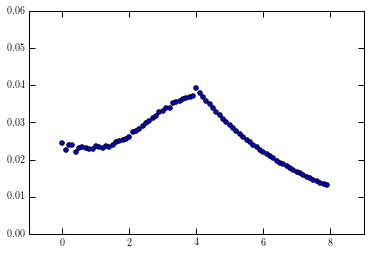

In [91]:
pylab.scatter(zArr, N_per_Mpc3)


(2.5, 3.5)

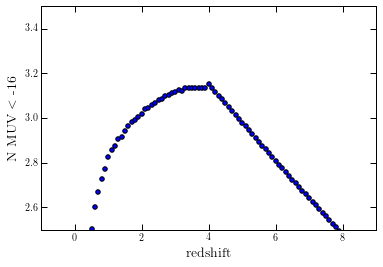

In [92]:
pylab.scatter(zArr, np.log10(totalN))
pylab.xlabel("redshift", fontsize=14)
pylab.ylabel("N MUV $<$ -16", fontsize=14)
pylab.ylim(2.5,3.5)



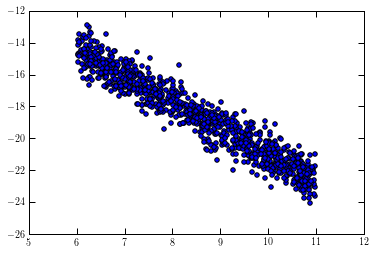

In [88]:
tempMass = np.random.uniform(size=1000)*5+6
test = assignMUV(tempMass,4)
pylab.scatter(tempMass,test)           